# Import relevant libraries

Imports the relevant python libraries needed.

In [1]:
import yahoo_fin
import yahoo_fin.stock_info as si
from yahoo_fin.stock_info import get_data
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



# Import and preprocess data

Data is scraped from Yahoo!Finance for all S&P 500 companies using the yahoo_fin Python library.

The below extracts the list of S&P500 companies' tickers. 2 of the tickers' values were replaced so that they can be searched using the yahoo_fin library.

In [2]:
sp500_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', attrs={'class': 'wikitable sortable'},header=0)[0]['Symbol']
sp500_list.replace(to_replace='BRK.B',value='BRK-B',inplace=True)
sp500_list.replace(to_replace='BF.B',value='BF-B',inplace=True)

The below extracts the information from Yahoo!Finance according to the start date and end date specified. Information for each ticker is extracted for the 'daily' time interval.

In [3]:
#Variables created.
historical_data = {}
counter = 0
key_err = 0
assert_err = 0
tickers_key_err = []
tickers_assert_err= []

#User input - start date and end date
while True:
    try:
        start_date_input = input("Please enter START date for the date range you want the model to be trained on. Format of input: DD-MM-YY.")
        start_date = datetime.strptime(start_date_input, '%d-%m-%y')
        print("Start date: " + str(start_date_input))
        break
    except ValueError:
        print("                             ", end='\r')
        print("Please ensure input is in the format DD-MM-YY.", end='\r')

while True:
    try:
        end_date_input = input("Please enter END date for the date range you want the model to be trained on. Format of input: DD-MM-YY.")
        end_date = datetime.strptime(end_date_input, '%d-%m-%y')
        print("End date: " + str(end_date_input))
        break
    except ValueError:
        print("                             ", end='\r')
        print("Please ensure input is in the format DD-MM-YY.", end='\r')


for ticker in sp500_list:
    counter += 1
    print("                             ", end='\r')
    print(str(ticker) + " " + str(counter), end='\r')
    try:
        historical_data[ticker] = get_data(ticker, start_date = start_date_input, end_date = end_date_input)
        historical_data[ticker] = historical_data[ticker].drop(labels='ticker',axis=1)
        historical_data[ticker].columns = str(ticker) + "_" + historical_data[ticker].columns
        
    except KeyError:
        historical_data[ticker] = None
        key_err += 1
        tickers_key_err.append(ticker)
    except AssertionError:
        historical_data[ticker] = None
        assert_err += 1
        tickers_assert_err.append(ticker)
        
print("No. of stocks with data successfully generated: " + str(counter-key_err-assert_err) + ".")
print("No. of stocks with KeyError: " + str(key_err) + ".")
if key_err>0:
    print("Tickers with KeyError (to investigate if needed): " + str(tickers_key_err))
print("No. of stocks with AssertionError: " + str(assert_err) + ".")
if assert_err>0:
    print("Tickers with AssertionError (to investigate if needed): " + str(tickers_assert_err))

Please enter START date for the date range you want the model to be trained on. Format of input: DD-MM-YY.01-01-00
Start date: 01-01-00
Please enter END date for the date range you want the model to be trained on. Format of input: DD-MM-YY.30-11-20
End date: 30-11-20
No. of stocks with data successfully generated: 505.
No. of stocks with KeyError: 0.
No. of stocks with AssertionError: 0.


Merge the dictionary of dataframes column-wise on the index (which is the date). Drop all columns with NaN values.

In [4]:
merged_data = pd.concat(historical_data, axis=1)
merged_data = merged_data.dropna(axis='columns')
merged_tickers = list(set(merged_data.columns.get_level_values(0))) #Store all remaining tickers' names for further use later.
merged_data.columns = merged_data.columns.droplevel(0)

merged_data.head()
merged_data.shape


(5261, 2256)

# Picking of target stock

User to pick the target stock out of the remaining tickers in the pre-processed data for training and testing of the model.

In [5]:
print("List of all tickers in data: \n" + str(merged_tickers))
chosen_ticker = input("Indicate a ticker. Pick one from the print statement below.")
chosen_adjclose = chosen_ticker + "_adjclose"

List of all tickers in data: 
['WAT', 'SJM', 'IFF', 'AXP', 'ZION', 'JNPR', 'EL', 'ADM', 'OKE', 'PRGO', 'PXD', 'DISH', 'SEE', 'GWW', 'ODFL', 'AMD', 'FDX', 'CCL', 'INTU', 'ALL', 'DD', 'ECL', 'SYK', 'WBA', 'PBCT', 'MDT', 'MU', 'AES', 'CMS', 'NVR', 'CHRW', 'CVX', 'NI', 'TFC', 'LHX', 'REGN', 'URI', 'CLX', 'PGR', 'PVH', 'HD', 'ADI', 'MCD', 'MSI', 'HIG', 'CDNS', 'EMR', 'RTX', 'HOLX', 'GIS', 'PSA', 'SYY', 'CL', 'SBUX', 'COST', 'RJF', 'JCI', 'REG', 'EA', 'MRO', 'AJG', 'PNR', 'EFX', 'MTB', 'STZ', 'UDR', 'VRSN', 'CINF', 'BMY', 'BIO', 'SO', 'F', 'VZ', 'USB', 'CMI', 'BAX', 'DTE', 'BIIB', 'ES', 'ROK', 'SLG', 'SNPS', 'WFC', 'AZO', 'ABC', 'POOL', 'TRV', 'RHI', 'VNO', 'BWA', 'NEM', 'HSIC', 'PPL', 'PKI', 'PHM', 'SCHW', 'FITB', 'GS', 'T', 'HUM', 'CSX', 'XRAY', 'SPG', 'KIM', 'SBAC', 'NUE', 'L', 'EXPD', 'DUK', 'VLO', 'ROST', 'GILD', 'TFX', 'ZBRA', 'MNST', 'DOV', 'COO', 'DRE', 'ORCL', 'AEE', 'COF', 'LRCX', 'NOC', 'AVY', 'ROP', 'TIF', 'NKE', 'WMB', 'IDXX', 'BK', 'TDY', 'FLIR', 'TAP', 'AMZN', 'PPG', 'TROW', '

# Exploratory Data Analysis

Plot of price over time period for chosen stock's adjusted close, open, high, low and close prices.

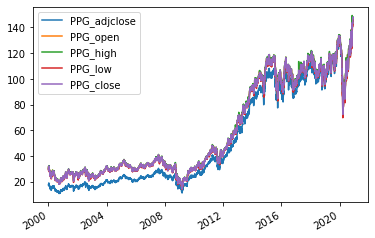

In [6]:

%matplotlib inline
merged_data[chosen_adjclose].plot()
merged_data[chosen_ticker+"_open"].plot()
merged_data[chosen_ticker+"_high"].plot()
merged_data[chosen_ticker+"_low"].plot()
merged_data[chosen_ticker+"_close"].plot()


plt.legend()

Summary statistics over entire time period for chosen stock using pandas' describe function.

In [7]:
merged_data[chosen_adjclose].describe()

count    5261.000000
mean       51.795033
std        37.803501
min        10.860846
25%        20.305990
50%        28.547291
75%        93.142494
max       147.929993
Name: PPG_adjclose, dtype: float64

# Creating Target and Feature Variables

In [8]:
lagged_days = int(input("How many days would you like to lag the features by?"))
print(merged_data)
features_wo_pca = merged_data.drop(columns = [chosen_adjclose]).shift(lagged_days).dropna()
print(features_wo_pca)
target = merged_data[chosen_adjclose][lagged_days:]
print(target)

How many days would you like to lag the features by?1
              MMM_open    MMM_high     MMM_low   MMM_close  MMM_adjclose  \
2000-01-03   48.031250   48.250000   47.031250   47.187500     27.815882   
2000-01-04   46.437500   47.406250   45.312500   45.312500     26.710594   
2000-01-05   45.562500   48.125000   45.562500   46.625000     27.484299   
2000-01-06   47.156250   51.250000   47.156250   50.375000     29.694832   
2000-01-07   50.562500   51.906250   49.968750   51.375000     30.284302   
...                ...         ...         ...         ...           ...   
2020-11-20  171.500000  172.949997  170.960007  172.889999    172.889999   
2020-11-23  173.759995  174.860001  173.449997  174.139999    174.139999   
2020-11-24  175.000000  177.220001  174.899994  177.080002    177.080002   
2020-11-25  176.839996  177.339996  175.449997  177.119995    177.119995   
2020-11-27  177.820007  179.630005  175.570007  176.889999    176.889999   

            MMM_volume    ABT_ope

# Dimensionality Reduction Using PCA

Implement Principal Component Analysis (PCA) for dimensionality reduction using the sklearn library. This would help us to decide which features to pick to have the most explained variance with the least number of features.

Below, we set the n_components to be 0.999. This means that the number of components chosen will be such that 99.9% of the variance is explained by them.

In [9]:
pca = PCA(n_components = 0.999)


Scale the data using sklearn's StandardScaler module to ensure that the features all follow a standard normal distribution with a mean of zero and standard deviation of one.

In [10]:
stdscaler = StandardScaler()
features_wo_pca_scaled = pd.DataFrame(stdscaler.fit_transform(features_wo_pca), 
                              columns = features_wo_pca.columns, 
                              index = features_wo_pca.index)

We plot the cumulative explained variance against the number of components to get an illustration of the amount of variance explained by each cumulative component.

Text(0, 0.5, 'cumulative explained variance')

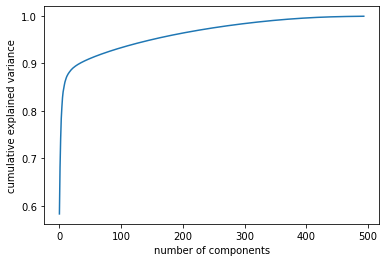

In [11]:
pca.fit(features_wo_pca_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

The following prints out the contribution of each original individual feature column to each newly created PCA component row. The index here represents each PCA component; the columns represent each original individual feature; the values represent the amount contributed by the individual feature to the PCA component. We will be able to identify which features contribute the most to each component if needed.

In [12]:
feature_contribution = pd.DataFrame(pca.components_, columns = features_wo_pca_scaled.columns)
feature_contribution.head()

,MMM_open,MMM_high,MMM_low,MMM_close,MMM_adjclose,MMM_volume,ABT_open,ABT_high,ABT_low,ABT_close,...,ZBRA_low,ZBRA_close,ZBRA_adjclose,ZBRA_volume,ZION_open,ZION_high,ZION_low,ZION_close,ZION_adjclose,ZION_volume
0,0.025837,0.025859,0.025807,0.025829,0.026505,-0.009413,0.025724,0.025689,0.025771,0.025730,...,0.024276,0.024258,0.024258,-0.002239,-0.004886,-0.004971,-0.004801,-0.004891,-0.000106,0.003844
1,0.004188,0.004098,0.004297,0.004228,0.002882,0.005224,-0.012191,-0.012319,-0.012076,-0.012216,...,-0.020621,-0.020686,-0.020686,-0.012513,-0.040248,-0.040268,-0.040226,-0.040254,-0.037728,0.036557
2,-0.016412,-0.016053,-0.016899,-0.016482,-0.009750,0.036223,0.021023,0.021348,0.020579,0.020965,...,0.022288,0.022505,0.022505,-0.002168,-0.032987,-0.032370,-0.033579,-0.032993,-0.031428,0.035475
3,0.000041,0.000014,-0.000042,-0.000042,-0.002402,0.009368,-0.000332,-0.000386,-0.000317,-0.000363,...,0.007968,0.007871,0.007871,0.007022,0.063765,0.064026,0.063539,0.063740,0.070171,-0.009567
4,-0.014038,-0.013875,-0.014288,-0.014129,-0.010900,0.008260,0.000299,0.000392,0.000220,0.000322,...,-0.004203,-0.004170,-0.004170,-0.002696,0.005160,0.006096,0.004080,0.005032,0.005744,0.014348


In [13]:
features_w_pca = pd.DataFrame(pca.fit_transform(features_wo_pca_scaled), index = features_wo_pca_scaled.index)
print(features_w_pca)
print(features_w_pca.shape)

                  0          1          2          3          4          5    \
2000-01-04 -35.970564 -23.545983  -4.632678 -17.457543  14.528767  -0.317679   
2000-01-05 -36.847195 -22.738132  -3.598411 -17.290344  13.295097  -0.339582   
2000-01-06 -37.498239 -22.275775  -2.547413 -16.560103  12.747114   1.036281   
2000-01-07 -37.310731 -21.747055  -2.933164 -16.133822  12.179301   1.005124   
2000-01-10 -36.601279 -21.803710  -3.397929 -16.201532  12.670453   1.902949   
...               ...        ...        ...        ...        ...        ...   
2020-11-20  90.134574 -29.332602  29.592663   1.428946   1.375385 -14.486276   
2020-11-23  90.243500 -29.247349  29.356183   1.094006   1.319999 -14.340001   
2020-11-24  91.089589 -29.061337  29.032189   1.790515   1.882463 -14.185180   
2020-11-25  93.277028 -26.688010  30.736155   3.258474   3.711166 -10.347977   
2020-11-27  92.644922 -29.568476  26.787232   1.967131   2.756135 -14.901412   

                  6         7          

Determine the proportion of the split between train and test set. Here, arbitrarily determined as 90% for training, 10% for testing. Note: For extremely large data sets, it may be good to specify a number value (as opposed to a percentage) for the test set as the test set need not be too large, and also it would be good for the training set to be larger where possible.


In [14]:
traintest_index = int(len(features_w_pca) * 0.9) #This returns the row number for the boundary between train and test sets.
traintest_value = features_w_pca.index[traintest_index] #This returns the datetimeindex at the row where we want to split between train and test sets.
features_train = features_w_pca[features_w_pca.index <= traintest_value]
features_test = features_w_pca[features_w_pca.index > traintest_value]
target_train = target[target.index <= traintest_value]
target_test = target[target.index > traintest_value]

print("Check of train-test split: ")
print("features = " + str(len(features_w_pca)))
print("features_train = " + str(len(features_train)))
print("features_test = " + str(len(features_test)))


Check of train-test split: 
features = 5260
features_train = 4735
features_test = 525


Perform a min-max scaling on the features for both train and test sets using sklearn's MinMaxScaler class to ensure that data is all within the same scale. Note that we use 'fit_transform' for the training data and 'transform' for the testing data. Reason for this is so that the model is not trained on the testing data as well but uses the same mean and variance (and hence keeps it on the same scale) as the training data.

In [15]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
features_train = pd.DataFrame(minmax_scaler.fit_transform(features_train), 
                              columns = features_train.columns, 
                              index = features_train.index)
features_train.head()

,0,1,2,3,4,5,6,7,8,9,...,484,485,486,487,488,489,490,491,492,493
2000-01-04,0.080297,0.086183,0.266844,0.084187,0.716228,0.306098,0.636272,0.266724,0.740357,0.753330,...,0.498172,0.380651,0.605861,0.256958,0.953062,0.243971,1.000000,0.282063,0.494907,0.613443
2000-01-05,0.072464,0.098843,0.282264,0.087731,0.686941,0.305709,0.630061,0.253495,0.708586,0.735521,...,0.454825,0.471665,0.689480,0.481864,0.835055,0.216930,0.953392,0.329382,0.524241,0.589327
2000-01-06,0.066646,0.106088,0.297935,0.103207,0.673932,0.330124,0.630153,0.322551,0.703786,0.717440,...,0.548503,0.514861,0.753815,0.610375,0.753785,0.293847,0.884298,0.364046,0.605004,0.565087
2000-01-07,0.068322,0.114374,0.292183,0.112242,0.660452,0.329571,0.619687,0.305633,0.681750,0.684828,...,0.600167,0.595048,0.800247,0.627028,0.712771,0.299243,0.667301,0.444813,0.720993,0.531317
2000-01-10,0.074661,0.113486,0.285254,0.110807,0.672112,0.345503,0.627674,0.333786,0.695814,0.688933,...,0.617299,0.416793,0.759628,0.642487,0.420833,0.298311,0.637156,0.610427,0.669134,0.663382


In [16]:
features_test = pd.DataFrame(minmax_scaler.transform(features_test), 
                             columns = features_test.columns, 
                             index = features_test.index)
features_test.head()

,0,1,2,3,4,5,6,7,8,9,...,484,485,486,487,488,489,490,491,492,493
2018-10-29,0.875215,0.426938,0.473649,0.531316,0.481808,0.499672,0.250045,0.739127,0.500829,0.694783,...,0.289251,0.522194,0.443260,0.437717,0.397387,0.483181,0.543999,0.559146,0.486818,0.503127
2018-10-30,0.878152,0.396357,0.430161,0.517221,0.456990,0.443193,0.248349,0.675057,0.439591,0.632813,...,0.339341,0.517668,0.589427,0.532674,0.330007,0.631021,0.403933,0.389787,0.614394,0.452228
2018-10-31,0.888237,0.411554,0.459149,0.530725,0.482504,0.499167,0.265653,0.727191,0.483373,0.685574,...,0.622000,0.470782,0.452861,0.420491,0.430160,0.491993,0.447866,0.577698,0.533287,0.428118
2018-11-01,0.903715,0.422191,0.459827,0.536142,0.495967,0.503461,0.255616,0.737841,0.541758,0.686449,...,0.574503,0.402990,0.481606,0.593483,0.217529,0.486379,0.164896,0.350052,0.552708,0.500363
2018-11-02,0.910731,0.379336,0.408777,0.517349,0.472773,0.439411,0.216293,0.655689,0.497518,0.629204,...,0.519625,0.393549,0.422710,0.660495,0.266668,0.444432,0.224326,0.318285,0.665808,0.463792


Sequence generation

In [17]:
sequence_length = 5
def gen_sequence(df, seq_length):
    data_array = df.values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

seq_array = np.array(list(gen_sequence(features_train,sequence_length)))
print(seq_array.shape)

(4730, 5, 494)


In [18]:
def gen_labels(df, seq_length):
    data_array = df.values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements]

label_array = np.array(list(gen_labels(target_train,sequence_length)))
label_array.shape

(4730,)

In [19]:
seq_array_test = np.array(list(gen_sequence(features_test,sequence_length)))
seq_array_test.shape

(520, 5, 494)

In [20]:
label_array_test = np.array(list(gen_labels(target_test,sequence_length)))
label_array_test.shape

(520,)

# Benchmark Model - Linear Regression (with PCA)

Here, we show the results of linear regression implemented on the principal components generated from the PCA earlier. Notice that the results are significantly better compared to without implementing PCA.

In [21]:
from sklearn.linear_model import LinearRegression

linearregression = LinearRegression()
linearregression.fit(np.array([seq_array[i][sequence_length-1] for i in range(seq_array.shape[0])]),label_array)

LinearRegression()

In [22]:
prediction = linearregression.predict(np.array([seq_array_test[i][sequence_length-1] for i in range(seq_array_test.shape[0])]))


In [23]:
pd.DataFrame([prediction,label_array_test]).T\
.rename({0:'prediction',1:'truth'},axis=1)\
.set_index(target.index[target.index> target.index[int(len(target) * 0.9) + sequence_length]])\
.to_csv('LR_prediction.csv')

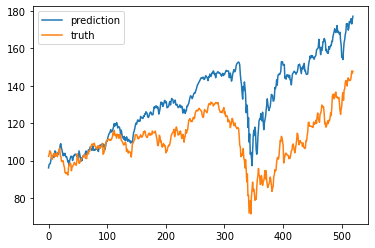

In [24]:
plt.plot(prediction, label='prediction')
plt.plot(label_array_test, label='truth')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import r2_score, mean_squared_error
r2_score(label_array_test,prediction),np.sqrt(mean_squared_error(label_array_test,prediction))

(-2.398249512825723, 24.880996363469674)

# Neural Network

LSTM model

In [26]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from numpy.random import seed
import random as python_random
import tensorflow
tensorflow.random.set_seed(1)
seed(1)
python_random.seed(123)

# build the network
nb_features = seq_array.shape[2]
print(sequence_length)
print(nb_features)
model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=75,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mae', optimizer='nadam', metrics=['mean_squared_error'])

5
494


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 75)             171000    
_________________________________________________________________
dropout (Dropout)            (None, 5, 75)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             25200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [28]:
history = model.fit(seq_array, label_array, epochs=200, batch_size=32, validation_split=0.1, verbose=2)

Epoch 1/200
134/134 - 3s - loss: 26.2433 - mean_squared_error: 1537.9495 - val_loss: 84.9795 - val_mean_squared_error: 7257.1191
Epoch 2/200
134/134 - 1s - loss: 21.3572 - mean_squared_error: 1218.4865 - val_loss: 80.9094 - val_mean_squared_error: 6581.9336
Epoch 3/200
134/134 - 1s - loss: 20.4954 - mean_squared_error: 1114.3938 - val_loss: 78.9523 - val_mean_squared_error: 6269.0723
Epoch 4/200
134/134 - 1s - loss: 20.2883 - mean_squared_error: 1071.7072 - val_loss: 78.1423 - val_mean_squared_error: 6141.8257
Epoch 5/200
134/134 - 1s - loss: 20.2496 - mean_squared_error: 1050.6176 - val_loss: 78.0015 - val_mean_squared_error: 6119.8384
Epoch 6/200
134/134 - 1s - loss: 20.3000 - mean_squared_error: 1058.7556 - val_loss: 77.9266 - val_mean_squared_error: 6108.1616
Epoch 7/200
134/134 - 1s - loss: 20.2539 - mean_squared_error: 1052.4231 - val_loss: 78.0357 - val_mean_squared_error: 6125.1821
Epoch 8/200
134/134 - 1s - loss: 20.2703 - mean_squared_error: 1057.9236 - val_loss: 78.0879 - va

Epoch 65/200
134/134 - 1s - loss: 3.2846 - mean_squared_error: 24.6408 - val_loss: 26.1188 - val_mean_squared_error: 737.0601
Epoch 66/200
134/134 - 1s - loss: 3.2759 - mean_squared_error: 25.1486 - val_loss: 13.4630 - val_mean_squared_error: 216.0095
Epoch 67/200
134/134 - 1s - loss: 3.1890 - mean_squared_error: 23.6523 - val_loss: 7.2634 - val_mean_squared_error: 72.3383
Epoch 68/200
134/134 - 1s - loss: 3.2884 - mean_squared_error: 25.5641 - val_loss: 16.7797 - val_mean_squared_error: 326.9397
Epoch 69/200
134/134 - 1s - loss: 3.1646 - mean_squared_error: 23.0167 - val_loss: 19.6743 - val_mean_squared_error: 435.2126
Epoch 70/200
134/134 - 1s - loss: 3.1358 - mean_squared_error: 22.6512 - val_loss: 5.7804 - val_mean_squared_error: 50.5913
Epoch 71/200
134/134 - 1s - loss: 3.4558 - mean_squared_error: 31.5961 - val_loss: 13.4362 - val_mean_squared_error: 213.4648
Epoch 72/200
134/134 - 1s - loss: 3.0899 - mean_squared_error: 21.7972 - val_loss: 18.5812 - val_mean_squared_error: 388.4

Epoch 130/200
134/134 - 1s - loss: 2.6303 - mean_squared_error: 16.5973 - val_loss: 15.5820 - val_mean_squared_error: 286.6652
Epoch 131/200
134/134 - 1s - loss: 2.5871 - mean_squared_error: 16.3531 - val_loss: 22.4570 - val_mean_squared_error: 558.4426
Epoch 132/200
134/134 - 1s - loss: 2.6550 - mean_squared_error: 16.9020 - val_loss: 9.2718 - val_mean_squared_error: 111.6396
Epoch 133/200
134/134 - 1s - loss: 2.6310 - mean_squared_error: 16.3316 - val_loss: 16.5488 - val_mean_squared_error: 319.4087
Epoch 134/200
134/134 - 1s - loss: 2.6123 - mean_squared_error: 16.3081 - val_loss: 21.0984 - val_mean_squared_error: 496.1030
Epoch 135/200
134/134 - 1s - loss: 2.5197 - mean_squared_error: 15.1549 - val_loss: 5.2996 - val_mean_squared_error: 41.0806
Epoch 136/200
134/134 - 1s - loss: 2.6509 - mean_squared_error: 17.1749 - val_loss: 11.2370 - val_mean_squared_error: 157.1369
Epoch 137/200
134/134 - 1s - loss: 2.5984 - mean_squared_error: 16.2733 - val_loss: 5.6527 - val_mean_squared_erro

Epoch 195/200
134/134 - 1s - loss: 2.3809 - mean_squared_error: 13.5434 - val_loss: 11.1317 - val_mean_squared_error: 157.9672
Epoch 196/200
134/134 - 1s - loss: 2.4527 - mean_squared_error: 14.5176 - val_loss: 10.3878 - val_mean_squared_error: 140.2453
Epoch 197/200
134/134 - 1s - loss: 2.4382 - mean_squared_error: 14.6444 - val_loss: 11.4089 - val_mean_squared_error: 165.7766
Epoch 198/200
134/134 - 1s - loss: 2.3792 - mean_squared_error: 13.9780 - val_loss: 14.2129 - val_mean_squared_error: 244.8403
Epoch 199/200
134/134 - 1s - loss: 2.4025 - mean_squared_error: 14.3239 - val_loss: 12.1411 - val_mean_squared_error: 184.4915
Epoch 200/200
134/134 - 1s - loss: 2.3401 - mean_squared_error: 13.3682 - val_loss: 10.8096 - val_mean_squared_error: 150.8063


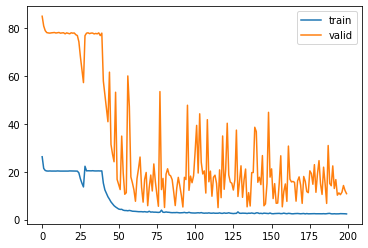

In [29]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [30]:
pd.DataFrame([history.history['loss'],history.history['val_loss']]).T\
.rename({0:'train',1:'test'},axis=1)\
.to_csv('history.csv')

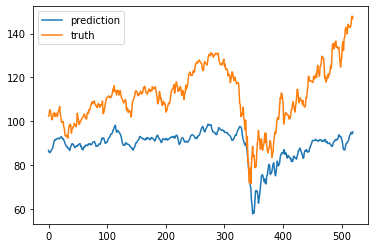

In [31]:
prediction = model.predict(seq_array_test)
plt.plot(prediction, label='prediction')
plt.plot(label_array_test, label='truth')
plt.legend()
plt.show()

In [32]:
pd.DataFrame([np.squeeze(prediction),label_array_test]).T\
.rename({0:'prediction',1:'truth'},axis=1)\
.set_index(target.index[target.index> target.index[int(len(target) * 0.9) + sequence_length]])\
.to_csv('LSTM_prediction.csv')

In [33]:
r2_score(label_array_test,prediction),np.sqrt(mean_squared_error(label_array_test,prediction))

(-2.358749986470324, 24.735971676074776)

In [34]:
print(mean_squared_error (label_array_test,prediction))

611.8682947595735
